# **Part B : News Article Classification :**

### Import necessary libraries

In [41]:
# Import necessary libraries

# Basic libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# NLP preprocessing
import nltk
nltk.download('punkt_tab')          # For word_tokenize
nltk.download('stopwords')          # For stopwords list

from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
nltk.download("averaged_perceptron_tagger_eng")
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Sklearn
from sklearn.model_selection import train_test_split      # For spliting datasets
from sklearn.preprocessing import LabelEncoder            # For converting ata in numerical
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer # For vectorization
from sklearn.model_selection import StratifiedKFold, cross_validate, cross_val_predict
from sklearn.preprocessing import LabelBinarizer, StandardScaler
from sklearn.calibration import CalibratedClassifierCV

from sklearn.linear_model import LogisticRegression       # For building a Logistic Regression model
from sklearn.naive_bayes import MultinomialNB             # For building a Naive Bayes model
from sklearn.svm import LinearSVC                         # For building a Support Vector Machine (SVM) model
from sklearn.ensemble import RandomForestClassifier       # For building a Random SForest Classifier model
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score, classification_report, confusion_matrix   
from gensim.models import Word2Vec

from wordcloud import WordCloud

import warnings
warnings.filterwarnings('ignore')      # For ignore warning massege


[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


In [6]:
# pip install scikeras
# !pip install catboost

## 1. Data Collection and Preprocessing :

### 1. Load the CSV File

In [7]:
# Load dataset
df = pd.read_csv("data_news.csv")  # update if .xlsx
df.head()


category                                           headline  \
0  WELLNESS              143 Miles in 35 Days: Lessons Learned   
1  WELLNESS       Talking to Yourself: Crazy or Crazy Helpful?   
2  WELLNESS  Crenezumab: Trial Will Gauge Whether Alzheimer...   
3  WELLNESS                     Oh, What a Difference She Made   
4  WELLNESS                                   Green Superfoods   

                                               links  \
0  https://www.huffingtonpost.com/entry/running-l...   
1  https://www.huffingtonpost.com/entry/talking-t...   
2  https://www.huffingtonpost.com/entry/crenezuma...   
3  https://www.huffingtonpost.com/entry/meaningfu...   
4  https://www.huffingtonpost.com/entry/green-sup...   

                                   short_description  \
0  Resting is part of training. I've confirmed wh...   
1  Think of talking to yourself as a tool to coac...   
2  The clock is ticking for the United States to ...   
3  If you want to be busy, keep trying to be perf...   
4  First, the bad news: Soda bread, corned beef a...   

                             keywords  
0                     running-lessons  
1           talking-to-yourself-crazy  
2  crenezumab-alzheimers-disease-drug  
3                     meaningful-life  
4                    green-superfoods

### 2. Basic inspection

In [8]:
# Basic inspection
print("Shape:", df.shape)
print(df.info())

print("\nDuplicate rows:", df.duplicated().sum())

Shape: (50000, 5)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   category           50000 non-null  object
 1   headline           50000 non-null  object
 2   links              50000 non-null  object
 3   short_description  50000 non-null  object
 4   keywords           47332 non-null  object
dtypes: object(5)
memory usage: 1.9+ MB
None

Duplicate rows: 4251


### ------>>> Treatment on Duplicate rows

In [9]:
# Remove duplicate rows
df = df.drop_duplicates()

print("After removing duplicates:")
print("Shape:", df.shape)
print("Duplicate rows:", df.duplicated().sum())

After removing duplicates:
Shape: (45749, 5)
Duplicate rows: 0


### 3. Checking Missing values in our dataset

In [10]:
# Check missing values in each column
print(df.isnull().sum())

# Check percentage of missing values
print((df.isnull().sum() / len(df)) * 100)


category                0
headline                0
links                   0
short_description       0
keywords             2379
dtype: int64
category             0.000000
headline             0.000000
links                0.000000
short_description    0.000000
keywords             5.200114
dtype: float64


### 4. Clean-up Step

In [11]:
# Fill missing keywords with empty string (optional)
df['keywords'] = df['keywords'].fillna('')   # Handle Missing Values

# Create text column (headline + description + optional keywords)
df['text'] = df['headline'] + " " + df['short_description'] + " " + df['keywords']

# Final dataset for modeling
df = df[['text', 'category']]
df.head()


text  category
0  143 Miles in 35 Days: Lessons Learned Resting ...  WELLNESS
1  Talking to Yourself: Crazy or Crazy Helpful? T...  WELLNESS
2  Crenezumab: Trial Will Gauge Whether Alzheimer...  WELLNESS
3  Oh, What a Difference She Made If you want to ...  WELLNESS
4  Green Superfoods First, the bad news: Soda bre...  WELLNESS

**Complete Context for the Model**

* Headline → short summary/title of the article.

* Short description → main content snippet.

* Keywords → important terms assigned to the article (like tags).

***If i only use headline or only description, the model might miss important information. Combining them ensures the model sees all available text.***

##  **Perform data cleaning and text preprocessing**

In [12]:
import re

def clean_text(text):
    # Remove HTML tags
    text = re.sub(r"<.*?>", "", text)
    
    # Lowercase
    text = text.lower()
    
    # Remove punctuation and numbers
    text = re.sub(r"[^a-z\s]", "", text)
    
    # Remove extra spaces
    text = re.sub(r"\s+", " ", text).strip()
    return text

# Apply cleaning on 'text' column (not 'review')
df['clean_text'] = df['text'].astype(str).apply(clean_text)

# Preview before & after
print("Original Text:\n", df['text'].iloc[0])
print("\nCleaned Text:\n", df['clean_text'].iloc[0])


Original Text:
 143 Miles in 35 Days: Lessons Learned Resting is part of training. I've confirmed what I sort of already knew: I'm not built for running streaks. I'm built for hard workouts three to five days a week with lots of cross training, physical therapy and foam rolling. But I've also confirmed that I'm stubborn with myself. running-lessons

Cleaned Text:
 miles in days lessons learned resting is part of training ive confirmed what i sort of already knew im not built for running streaks im built for hard workouts three to five days a week with lots of cross training physical therapy and foam rolling but ive also confirmed that im stubborn with myself runninglessons


### 2. Tokenization & Stopword Removal

In [13]:
# Define stopwords
stop_words = set(stopwords.words('english'))

# Tokenize (split by space) and remove stopwords
df['tokens'] = df['clean_text'].apply(lambda x: [word for word in x.split() if word not in stop_words])

# Preview
print(df[['clean_text','tokens']].head())


                                          clean_text  \
0  miles in days lessons learned resting is part ...   
1  talking to yourself crazy or crazy helpful thi...   
2  crenezumab trial will gauge whether alzheimers...   
3  oh what a difference she made if you want to b...   
4  green superfoods first the bad news soda bread...   

                                              tokens  
0  [miles, days, lessons, learned, resting, part,...  
1  [talking, crazy, crazy, helpful, think, talkin...  
2  [crenezumab, trial, gauge, whether, alzheimers...  
3  [oh, difference, made, want, busy, keep, tryin...  
4  [green, superfoods, first, bad, news, soda, br...  


### 3. Lemmatization

In [14]:
# Initialize lemmatizer
lemmatizer = WordNetLemmatizer()

# Apply lemmatization
df['lemmatized'] = df['tokens'].apply(lambda x: [lemmatizer.lemmatize(word) for word in x])

# Preview
print(df[['tokens','lemmatized']].head())


                                              tokens  \
0  [miles, days, lessons, learned, resting, part,...   
1  [talking, crazy, crazy, helpful, think, talkin...   
2  [crenezumab, trial, gauge, whether, alzheimers...   
3  [oh, difference, made, want, busy, keep, tryin...   
4  [green, superfoods, first, bad, news, soda, br...   

                                          lemmatized  
0  [mile, day, lesson, learned, resting, part, tr...  
1  [talking, crazy, crazy, helpful, think, talkin...  
2  [crenezumab, trial, gauge, whether, alzheimers...  
3  [oh, difference, made, want, busy, keep, tryin...  
4  [green, superfoods, first, bad, news, soda, br...  


#### **I chose Lemmatization here insted of Stemming:**

 *Because :*
* I chose Lemmatization here because it keeps the words meaningful, which is especially important for a news classification task, where context and accuracy matter more than speed.

## 2. Feature Extraction :

### Vectorization using techniques :

### 1. Bag of Words (BOW)

In [19]:
# Join lemmatized tokens back into string
df['final_text'] = df['lemmatized'].apply(lambda x: " ".join(x))

# BOW representation
bow_vectorizer = CountVectorizer()
X_bow = bow_vectorizer.fit_transform(df['final_text'])

print("BOW Shape:", X_bow.shape)
print(X_bow)

BOW Shape: (45749, 91739)
  (0, 51090)	1
  (0, 19302)	2
  (0, 45839)	1
  (0, 45422)	1
  (0, 66407)	1
  (0, 59245)	1
  (0, 82624)	2
  (0, 40391)	2
  (0, 16533)	2
  (0, 73508)	1
  (0, 2290)	1
  (0, 44018)	1
  (0, 37909)	3
  (0, 11156)	2
  (0, 68128)	1
  (0, 75529)	1
  (0, 33613)	1
  (0, 90273)	1
  (0, 81109)	1
  (0, 27736)	1
  (0, 87771)	1
  (0, 47147)	1
  (0, 18124)	1
  (0, 60645)	1
  (0, 80122)	1
  :	:
  (45746, 56800)	1
  (45746, 60989)	1
  (45746, 68945)	1
  (45747, 54531)	2
  (45747, 81424)	1
  (45747, 13459)	2
  (45747, 30039)	1
  (45747, 91222)	2
  (45747, 48302)	1
  (45747, 74367)	1
  (45747, 72058)	1
  (45747, 26392)	1
  (45747, 61284)	1
  (45747, 18729)	1
  (45747, 18736)	1
  (45748, 27587)	1
  (45748, 54914)	1
  (45748, 40032)	1
  (45748, 3853)	1
  (45748, 45368)	1
  (45748, 71274)	1
  (45748, 33023)	1
  (45748, 8581)	2
  (45748, 71961)	2
  (45748, 79408)	1


### 2. TF-IDF (Term Frequency – Inverse Document Frequency)

In [18]:
# TF-IDF representation
tfidf_vectorizer = TfidfVectorizer(max_features=5000)  # limit features to top 5000
X_tfidf = tfidf_vectorizer.fit_transform(df['final_text'])

print("TF-IDF Shape:", X_tfidf.shape)
print(X_tfidf)


TF-IDF Shape: (45749, 5000)
  (0, 2859)	0.15657352932081312
  (0, 1128)	0.17795294890759747
  (0, 2601)	0.14250318030889078
  (0, 2577)	0.14578929544105615
  (0, 3222)	0.11837327133269274
  (0, 4613)	0.3223455594829109
  (0, 2367)	0.2655858894749823
  (0, 921)	0.3541685191841077
  (0, 4157)	0.1675053715808769
  (0, 151)	0.13674257591088204
  (0, 2499)	0.15052547427641869
  (0, 2221)	0.3627063765030289
  (0, 589)	0.345992130158683
  (0, 3854)	0.15011004014520668
  (0, 2036)	0.13143592249272232
  (0, 4943)	0.1630438815507561
  (0, 4528)	0.12435302277656064
  (0, 1734)	0.13375974410556607
  (0, 4867)	0.10089346429163638
  (0, 2684)	0.1270965427804285
  (0, 1060)	0.18493119039841915
  (0, 3313)	0.16793577710741078
  (0, 4507)	0.1780593688786172
  (0, 3823)	0.18774465733500348
  (0, 152)	0.11067733671153794
  :	:
  (45746, 699)	0.23315874644804419
  (45746, 2382)	0.274454962570351
  (45746, 2879)	0.294411469474861
  (45746, 2571)	0.2549968233096374
  (45746, 379)	0.26437477489029226
  (4574

### 3. Word2Vec, or embeddings

In [22]:
# Prepare tokenized reviews (list of lists of words)
# Ensure 'lemmatized' column contains lists, then join if needed
df['lemmatized_str'] = df['lemmatized'].apply(lambda x: " ".join(x))
tokenized_reviews = [text.split() for text in df['lemmatized_str']]

# Train Word2Vec model
w2v_model = Word2Vec(
    sentences=tokenized_reviews,
    vector_size=100,   # size of embedding
    window=5,          # context window
    min_count=2,       # ignore words with freq < 2
    workers=4,         # number of CPU cores
    sg=1               # use skip-gram (better for small data), cbow if 0
)

# Function to get average word vectors for each review
def get_avg_vector(tokens, model, vector_size):
    vectors = [model.wv[word] for word in tokens if word in model.wv]
    if not vectors:  # if no word is in vocab
        return np.zeros(vector_size)
    return np.mean(vectors, axis=0)

# Apply to all reviews
X_word2vec = np.array([get_avg_vector(tokens, w2v_model, 100) for tokens in tokenized_reviews])

print("Word2Vec Shape:", X_word2vec.shape)
print(X_word2vec)


Word2Vec Shape: (45749, 100)
[[-1.30099043e-01  1.60535067e-01 -1.32938385e-01 ... -2.06321791e-01
   4.25742529e-02  2.82689056e-04]
 [-1.90442055e-01  2.81622738e-01 -9.40542743e-02 ... -9.71706659e-02
   1.10313833e-01  7.49817875e-04]
 [-4.80957404e-02  1.13035016e-01 -3.94542545e-01 ... -5.22063412e-02
   9.07008275e-02 -6.35154732e-03]
 ...
 [-1.62410796e-01  2.16482922e-01 -1.13085546e-01 ... -1.97363228e-01
   4.13743721e-04  5.93982525e-02]
 [ 2.09813807e-02  2.99374312e-01 -1.37892708e-01 ... -1.22458376e-01
   4.11441959e-02 -3.81488279e-02]
 [-9.65121090e-02  1.16311982e-01 -2.34457068e-02 ... -1.49686515e-01
  -1.01464383e-01  1.16291642e-01]]


###  **Exploratory Data Analysis (EDA)**

### 1. Check category distribution
* This helps you see if the dataset is balanced or imbalanced

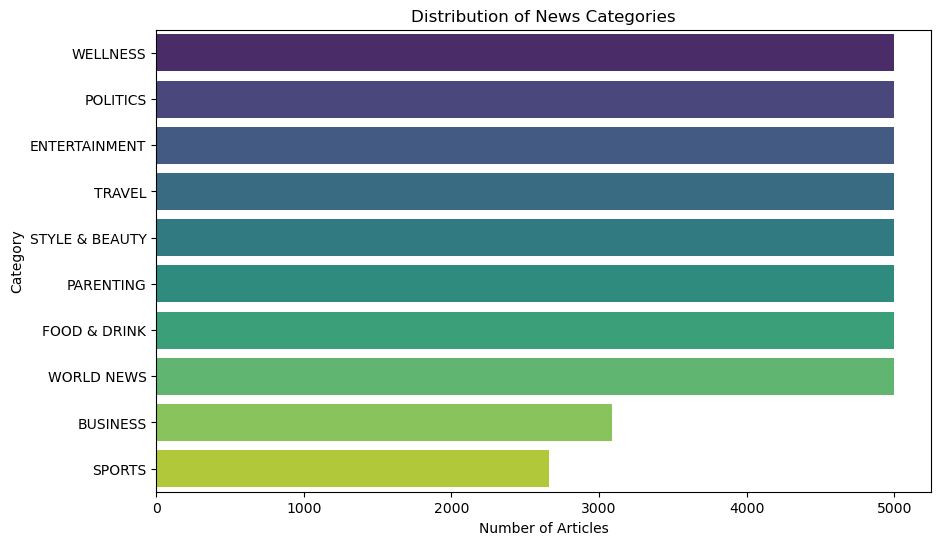

Percentage distribution per category:
 category
WELLNESS          10.929201
POLITICS          10.929201
ENTERTAINMENT     10.929201
TRAVEL            10.929201
STYLE & BEAUTY    10.929201
PARENTING         10.929201
FOOD & DRINK      10.929201
WORLD NEWS        10.929201
BUSINESS           6.756432
SPORTS             5.809963
Name: proportion, dtype: float64


In [23]:
# Category Distribution
plt.figure(figsize=(10,6))
sns.countplot(y='category', data=df, order=df['category'].value_counts().index, palette="viridis")
plt.title("Distribution of News Categories")
plt.xlabel("Number of Articles")
plt.ylabel("Category")
plt.show()


# Print percentage distribution
category_dist = df['category'].value_counts(normalize=True) * 100
print("Percentage distribution per category:\n", category_dist)


### 2️. Word Count Analysis

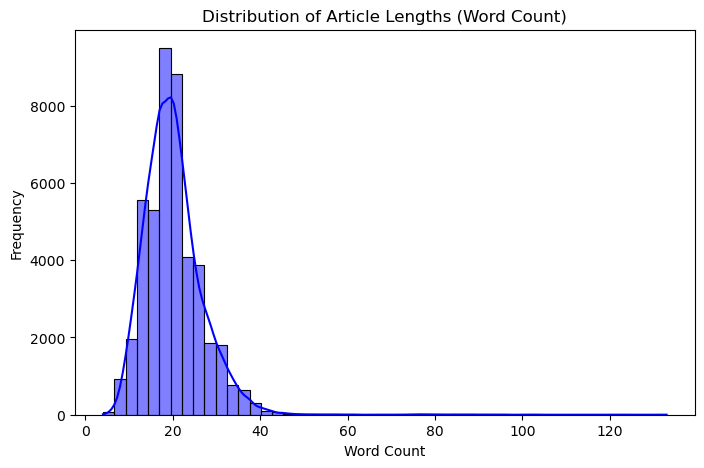


Average word count per category:
 category
WELLNESS          22.382600
TRAVEL            22.004000
PARENTING         21.749600
BUSINESS          21.668716
STYLE & BEAUTY    20.983200
WORLD NEWS        20.087800
POLITICS          19.507600
ENTERTAINMENT     18.106600
SPORTS            17.872084
FOOD & DRINK      16.517400
Name: word_count, dtype: float64


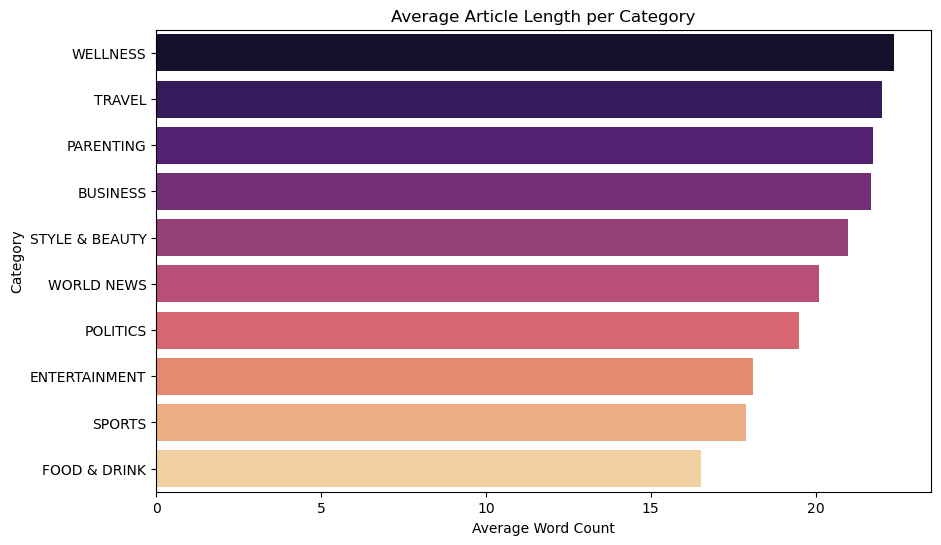

In [24]:
# Word Count Analysis
# Create word count column
df['word_count'] = df['final_text'].apply(lambda x: len(str(x).split()))

# Histogram of article lengths
plt.figure(figsize=(8,5))
sns.histplot(df['word_count'], bins=50, kde=True, color="blue")
plt.title("Distribution of Article Lengths (Word Count)")
plt.xlabel("Word Count")
plt.ylabel("Frequency")
plt.show()

# Average word count per category
avg_len = df.groupby('category')['word_count'].mean().sort_values(ascending=False)
print("\nAverage word count per category:\n", avg_len)

plt.figure(figsize=(10,6))
sns.barplot(x=avg_len.values, y=avg_len.index, palette="magma")
plt.title("Average Article Length per Category")
plt.xlabel("Average Word Count")
plt.ylabel("Category")
plt.show()

### 3️. Top Words per Category

In [25]:
from collections import Counter

# Top Words per Category
def get_top_words(texts, n=10):
    all_words = " ".join(texts).split()
    return Counter(all_words).most_common(n)

for cat in df['category'].unique():
    cat_texts = df[df['category'] == cat]['final_text']
    print(f"\nTop words in {cat}:")
    print(get_top_words(cat_texts, 10))



Top words in WELLNESS:
[('life', 889), ('health', 660), ('time', 657), ('u', 614), ('one', 613), ('way', 587), ('people', 587), ('study', 521), ('day', 505), ('new', 481)]

Top words in POLITICS:
[('state', 579), ('republican', 525), ('u', 490), ('new', 462), ('say', 457), ('clinton', 409), ('gop', 406), ('american', 369), ('one', 351), ('people', 346)]

Top words in ENTERTAINMENT:
[('new', 742), ('film', 498), ('star', 436), ('movie', 426), ('show', 404), ('one', 392), ('year', 375), ('first', 342), ('say', 317), ('time', 297)]

Top words in TRAVEL:
[('photo', 1005), ('travel', 939), ('world', 731), ('hotel', 643), ('new', 620), ('one', 584), ('best', 570), ('city', 548), ('day', 477), ('place', 455)]

Top words in STYLE & BEAUTY:
[('photo', 2791), ('style', 1023), ('fashion', 1008), ('look', 834), ('week', 741), ('new', 672), ('check', 553), ('dress', 547), ('want', 470), ('u', 442)]

Top words in PARENTING:
[('kid', 1457), ('child', 1438), ('parent', 1011), ('mom', 769), ('baby', 7

# 4️. WordCloud for all articles

In [26]:
from wordcloud import WordCloud

# WordCloud for all articles
text = " ".join(df['final_text'])
wordcloud = WordCloud(width=1000, height=600, background_color="white", colormap="plasma").generate(text)

plt.figure(figsize=(8,8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("WordCloud of All News Articles", fontsize=16)
plt.show()


# 5️. WordCloud per category (optional but impressive)

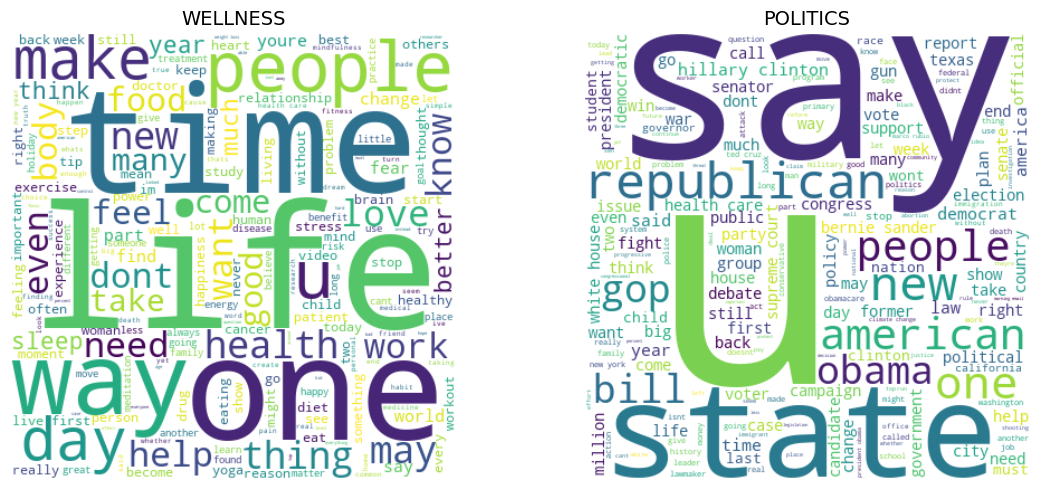

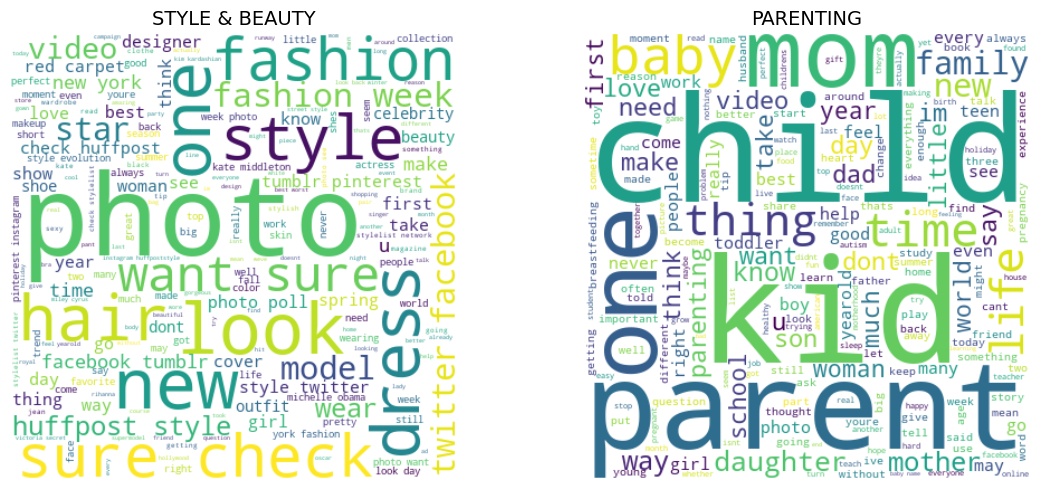

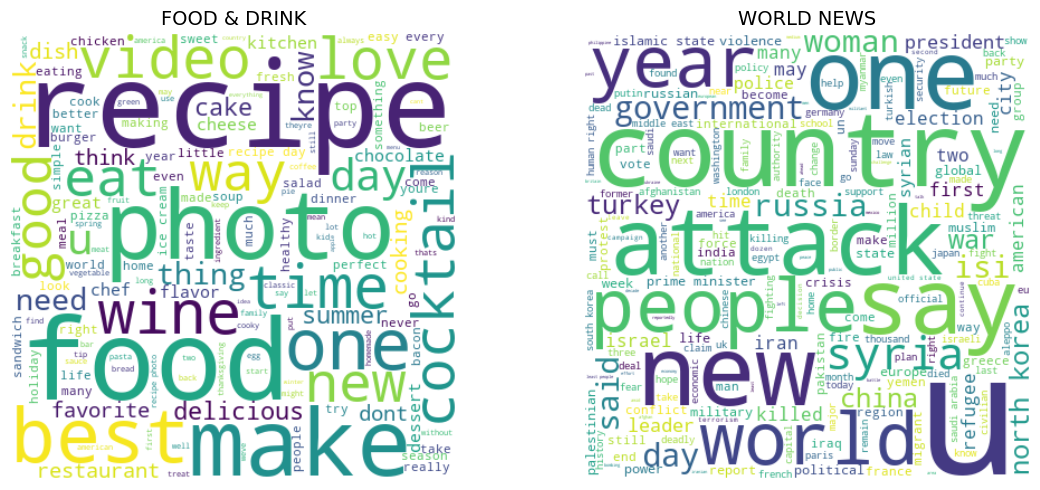

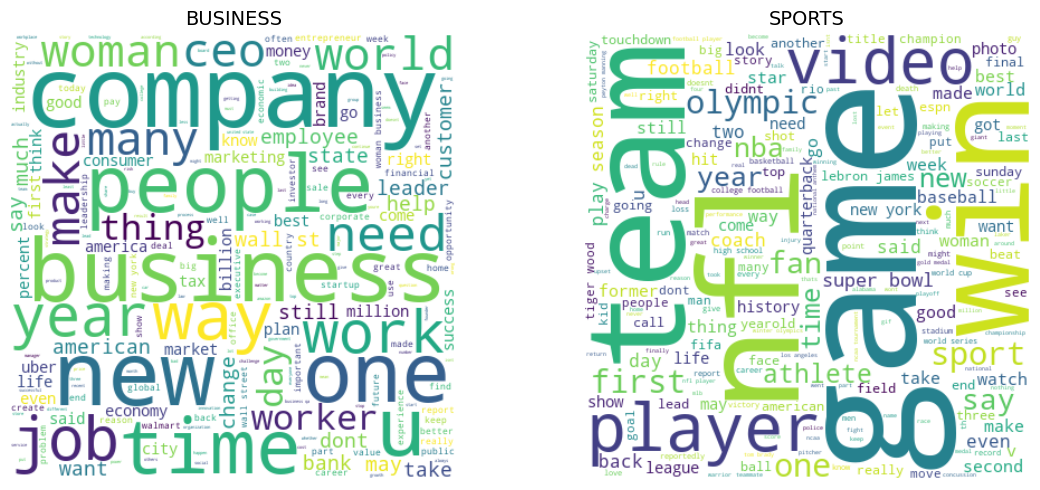

In [27]:
# WordCloud per category 

categories = df['category'].unique()

# Show first 4 categories, two wordclouds per row
for i in range(0, 10, 2):  # step 2 to get pairs
    cat1 = categories[i]
    cat2 = categories[i+1]

    text1 = " ".join(df[df['category']==cat1]['final_text'])
    text2 = " ".join(df[df['category']==cat2]['final_text'])

    wc1 = WordCloud(width=400, height=400, background_color="white").generate(text1)
    wc2 = WordCloud(width=400, height=400, background_color="white").generate(text2)

    # Create horizontal subplot
    fig, axes = plt.subplots(1, 2, figsize=(12,5))
    
    axes[0].imshow(wc1, interpolation="bilinear")
    axes[0].axis("off")
    axes[0].set_title(f"{cat1}", fontsize=14)

    axes[1].imshow(wc2, interpolation="bilinear")
    axes[1].axis("off")
    axes[1].set_title(f"{cat2}", fontsize=14)

    plt.tight_layout()
    plt.show()



## 3. Model Development and Training :

## **Based on TF-IDF** 
* TF-IDF is preferred over Bag-of-Words because it not only counts word occurrences but also gives higher weight to words that are important for a document and lower weight to common words that appear in many documents.
This helps the model focus on more informative terms and often improves classification accuracy.

### 1. *Logistic Regression*
### 2. *Naive Bayes*
### 3. *Support Vector Machine (SVM)*
### 4. *Random Forest*

## **Based on Word2Vec, or embeddings** 
### 5. *MLP Neural Network Metrics*

### **Train-Test Split for TF-IDF Features**

In [28]:
# ===== Train-Test Split for TF-IDF Features =====
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_tfidf,                 # TF-IDF features
    df['category'],         # Target column
    test_size=0.2,           # 20% for testing
    random_state=42,         # For reproducibility
    stratify=df['category'] # Keeps class distribution same in train & test
)

### 1. Logistic Regression

=== 5-fold Cross-Validation (Logistic Regression, TF-IDF) ===
Accuracy per fold:  [0.7884 0.784  0.7922 0.793  0.7836]
Precision per fold: [0.7887 0.7852 0.7933 0.7946 0.7854]
Recall per fold:    [0.7884 0.784  0.7922 0.793  0.7836]
F1 per fold:        [0.788  0.7836 0.7915 0.7926 0.7833]

CV Mean — Acc: 0.7883 | Prec: 0.7894 | Rec: 0.7883 | F1: 0.7878

=== Out-of-Fold (stitched) Metrics ===
Accuracy:  0.7883
Precision: 0.7893
Recall:    0.7883
F1-score:  0.7878
ROC-AUC:   0.9708

Classification Report (OOF):
                 precision    recall  f1-score   support

      BUSINESS       0.73      0.61      0.67      3091
 ENTERTAINMENT       0.76      0.80      0.78      5000
  FOOD & DRINK       0.85      0.86      0.85      5000
     PARENTING       0.78      0.79      0.78      5000
      POLITICS       0.77      0.75      0.76      5000
        SPORTS       0.85      0.72      0.78      2658
STYLE & BEAUTY       0.86      0.85      0.85      5000
        TRAVEL       0.80      0.80

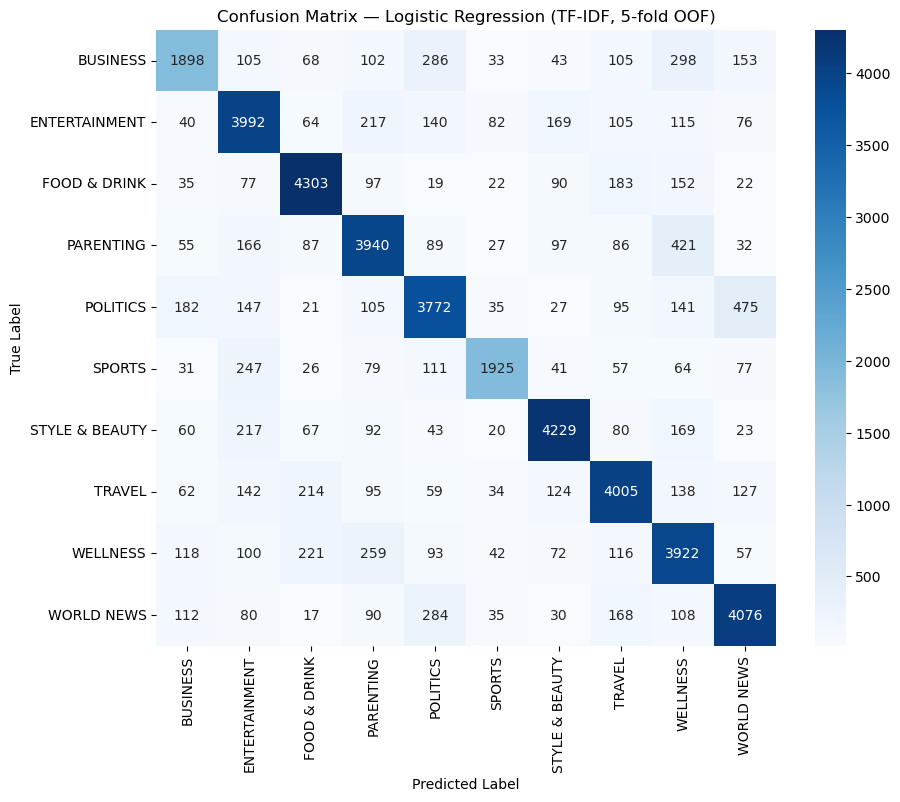

Model  Accuracy  Precision    Recall  F1-score  \
1  Logistic Regression (5-fold CV)  0.788258   0.789444  0.788258  0.787795   

    ROC-AUC  
1  0.970849

In [29]:
# ===== Logistic Regression with 5-fold Cross-Validation (TF-IDF) =====

X = X_tfidf           # X_tfidf: our TF-IDF matrix
y = df['category']    # df['category']: our labels

# Model + CV splitter
lr = LogisticRegression(max_iter=2000, multi_class='ovr')
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# ---- (A) Multi-metric cross-validation (per-fold + means) ----
scores = cross_validate(
    lr, X, y, cv=cv, n_jobs=-1,
    scoring={
        'accuracy': 'accuracy',
        'precision': 'precision_weighted',
        'recall': 'recall_weighted',
        'f1': 'f1_weighted'
    }
)

print("=== 5-fold Cross-Validation (Logistic Regression, TF-IDF) ===")
print("Accuracy per fold: ", np.round(scores['test_accuracy'], 4))
print("Precision per fold:", np.round(scores['test_precision'], 4))
print("Recall per fold:   ", np.round(scores['test_recall'], 4))
print("F1 per fold:       ", np.round(scores['test_f1'], 4))
cv_acc = scores['test_accuracy'].mean()
cv_prec = scores['test_precision'].mean()
cv_rec = scores['test_recall'].mean()
cv_f1 = scores['test_f1'].mean()
print(f"\nCV Mean — Acc: {cv_acc:.4f} | Prec: {cv_prec:.4f} | Rec: {cv_rec:.4f} | F1: {cv_f1:.4f}")

# ---- (B) Out-of-fold predictions for a single confusion matrix & ROC-AUC ----
# (cross_val_predict refits the model inside each fold and stitches predictions)
y_oof = cross_val_predict(lr, X, y, cv=cv, method='predict', n_jobs=-1)
y_oof_proba = cross_val_predict(lr, X, y, cv=cv, method='predict_proba', n_jobs=-1)

# OOF metrics (more “global” view)
oof_acc = accuracy_score(y, y_oof)
oof_prec = precision_score(y, y_oof, average='weighted', zero_division=0)
oof_rec = recall_score(y, y_oof, average='weighted', zero_division=0)
oof_f1 = f1_score(y, y_oof, average='weighted', zero_division=0)

# OOF ROC-AUC (needs binarized labels + probabilities)
lb = LabelBinarizer()
y_bin = lb.fit_transform(y)  # shape: (n_samples, n_classes)
oof_auc = roc_auc_score(y_bin, y_oof_proba, average='weighted', multi_class='ovr')

print("\n=== Out-of-Fold (stitched) Metrics ===")
print(f"Accuracy:  {oof_acc:.4f}")
print(f"Precision: {oof_prec:.4f}")
print(f"Recall:    {oof_rec:.4f}")
print(f"F1-score:  {oof_f1:.4f}")
print(f"ROC-AUC:   {oof_auc:.4f}")

print("\nClassification Report (OOF):\n",
      classification_report(y, y_oof, zero_division=0))

# Confusion Matrix (OOF)
classes_sorted = sorted(y.unique())
cm = confusion_matrix(y, y_oof, labels=classes_sorted)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=classes_sorted, yticklabels=classes_sorted)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix — Logistic Regression (TF-IDF, 5-fold OOF)")
plt.show()

# Save CV result (mean metrics + AUC from OOF)
result1_cv = pd.DataFrame({
    "Model": ["Logistic Regression (5-fold CV)"],
    "Accuracy": [cv_acc],
    "Precision": [cv_prec],
    "Recall": [cv_rec],
    "F1-score": [cv_f1],
    "ROC-AUC": [oof_auc]
}, index=[1])

result1_cv


### 2. Naive Bayes

In [30]:
# ===== Naive Bayes with 5-fold Cross-Validation (TF-IDF) =====

X = X_tfidf             # X_tfidf: our TF-IDF matrix
y = df['category']      # df['category']: our labels

# Model + CV splitter
nb = MultinomialNB()
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# ---- (A) Multi-metric cross-validation ----
scores = cross_validate(
    nb, X, y, cv=cv, n_jobs=-1,
    scoring={
        'accuracy': 'accuracy',
        'precision': 'precision_weighted',
        'recall': 'recall_weighted',
        'f1': 'f1_weighted'
    }
)

print("=== 5-fold Cross-Validation (Naive Bayes, TF-IDF) ===")
print("Accuracy per fold: ", np.round(scores['test_accuracy'], 4))
print("Precision per fold:", np.round(scores['test_precision'], 4))
print("Recall per fold:   ", np.round(scores['test_recall'], 4))
print("F1 per fold:       ", np.round(scores['test_f1'], 4))
cv_acc = scores['test_accuracy'].mean()
cv_prec = scores['test_precision'].mean()
cv_rec = scores['test_recall'].mean()
cv_f1 = scores['test_f1'].mean()
print(f"\nCV Mean — Acc: {cv_acc:.4f} | Prec: {cv_prec:.4f} | Rec: {cv_rec:.4f} | F1: {cv_f1:.4f}")

# ---- (B) Out-of-fold predictions for confusion matrix & ROC-AUC ----
y_oof = cross_val_predict(nb, X, y, cv=cv, method='predict', n_jobs=-1)
y_oof_proba = cross_val_predict(nb, X, y, cv=cv, method='predict_proba', n_jobs=-1)

# OOF metrics
oof_acc = accuracy_score(y, y_oof)
oof_prec = precision_score(y, y_oof, average='weighted', zero_division=0)
oof_rec = recall_score(y, y_oof, average='weighted', zero_division=0)
oof_f1 = f1_score(y, y_oof, average='weighted', zero_division=0)

# ROC-AUC (multiclass)
lb = LabelBinarizer()
y_bin = lb.fit_transform(y)
oof_auc = roc_auc_score(y_bin, y_oof_proba, average='weighted', multi_class='ovr')

print("\n=== Out-of-Fold (stitched) Metrics ===")
print(f"Accuracy:  {oof_acc:.4f}")
print(f"Precision: {oof_prec:.4f}")
print(f"Recall:    {oof_rec:.4f}")
print(f"F1-score:  {oof_f1:.4f}")
print(f"ROC-AUC:   {oof_auc:.4f}")

print("\nClassification Report (OOF):\n",
      classification_report(y, y_oof, zero_division=0))

# Confusion Matrix
classes_sorted = sorted(y.unique())
cm = confusion_matrix(y, y_oof, labels=classes_sorted)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=classes_sorted, yticklabels=classes_sorted)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix — Naive Bayes (TF-IDF, 5-fold OOF)")
plt.show()

# Save result
result2_cv = pd.DataFrame({
    "Model": ["Naive Bayes (5-fold CV)"],
    "Accuracy": [cv_acc],
    "Precision": [cv_prec],
    "Recall": [cv_rec],
    "F1-score": [cv_f1],
    "ROC-AUC": [oof_auc]
}, index=[2])

result2_cv


=== 5-fold Cross-Validation (Naive Bayes, TF-IDF) ===
Accuracy per fold:  [0.7719 0.7642 0.7718 0.7783 0.7636]
Precision per fold: [0.7752 0.7689 0.7764 0.7835 0.767 ]
Recall per fold:    [0.7719 0.7642 0.7718 0.7783 0.7636]
F1 per fold:        [0.7706 0.7627 0.7703 0.7768 0.7616]

CV Mean — Acc: 0.7699 | Prec: 0.7742 | Rec: 0.7699 | F1: 0.7684

=== Out-of-Fold (stitched) Metrics ===
Accuracy:  0.7699
Precision: 0.7740
Recall:    0.7699
F1-score:  0.7684
ROC-AUC:   0.9687

Classification Report (OOF):
                 precision    recall  f1-score   support

      BUSINESS       0.77      0.52      0.62      3091
 ENTERTAINMENT       0.77      0.77      0.77      5000
  FOOD & DRINK       0.83      0.86      0.84      5000
     PARENTING       0.68      0.78      0.73      5000
      POLITICS       0.75      0.76      0.76      5000
        SPORTS       0.89      0.65      0.75      2658
STYLE & BEAUTY       0.85      0.82      0.83      5000
        TRAVEL       0.77      0.81      0.

Model  Accuracy  Precision   Recall  F1-score   ROC-AUC
2  Naive Bayes (5-fold CV)   0.76994   0.774185  0.76994  0.768397  0.968739

### 3. Support Vector Machine (SVM)

In [31]:
# ===== Support Vector Machine (Linear SVM) with 5-fold Cross-Validation =====

from sklearn.calibration import CalibratedClassifierCV

X = X_tfidf            # X_tfidf: our TF-IDF matrix
y = df['category']     # df['category']: our labels

# Base SVM (LinearSVC does not support predict_proba, so we calibrate it)
base_svm = LinearSVC(max_iter=2000, random_state=42)
svm = CalibratedClassifierCV(base_svm, cv=3)  # adds probability estimates

# CV splitter
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# ---- (A) Multi-metric cross-validation ----
scores = cross_validate(
    svm, X, y, cv=cv, n_jobs=-1,
    scoring={
        'accuracy': 'accuracy',
        'precision': 'precision_weighted',
        'recall': 'recall_weighted',
        'f1': 'f1_weighted'
    }
)

print("=== 5-fold Cross-Validation (SVM, TF-IDF) ===")
print("Accuracy per fold: ", np.round(scores['test_accuracy'], 4))
print("Precision per fold:", np.round(scores['test_precision'], 4))
print("Recall per fold:   ", np.round(scores['test_recall'], 4))
print("F1 per fold:       ", np.round(scores['test_f1'], 4))
cv_acc = scores['test_accuracy'].mean()
cv_prec = scores['test_precision'].mean()
cv_rec = scores['test_recall'].mean()
cv_f1 = scores['test_f1'].mean()
print(f"\nCV Mean — Acc: {cv_acc:.4f} | Prec: {cv_prec:.4f} | Rec: {cv_rec:.4f} | F1: {cv_f1:.4f}")

# ---- (B) Out-of-fold predictions ----
y_oof = cross_val_predict(svm, X, y, cv=cv, method='predict', n_jobs=-1)
y_oof_proba = cross_val_predict(svm, X, y, cv=cv, method='predict_proba', n_jobs=-1)

# OOF metrics
oof_acc = accuracy_score(y, y_oof)
oof_prec = precision_score(y, y_oof, average='weighted', zero_division=0)
oof_rec = recall_score(y, y_oof, average='weighted', zero_division=0)
oof_f1 = f1_score(y, y_oof, average='weighted', zero_division=0)

# ROC-AUC (multiclass)
lb = LabelBinarizer()
y_bin = lb.fit_transform(y)
oof_auc = roc_auc_score(y_bin, y_oof_proba, average='weighted', multi_class='ovr')

print("\n=== Out-of-Fold (stitched) Metrics ===")
print(f"Accuracy:  {oof_acc:.4f}")
print(f"Precision: {oof_prec:.4f}")
print(f"Recall:    {oof_rec:.4f}")
print(f"F1-score:  {oof_f1:.4f}")
print(f"ROC-AUC:   {oof_auc:.4f}")

print("\nClassification Report (OOF):\n",
      classification_report(y, y_oof, zero_division=0))

# Confusion Matrix
classes_sorted = sorted(y.unique())
cm = confusion_matrix(y, y_oof, labels=classes_sorted)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=classes_sorted, yticklabels=classes_sorted)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix — SVM (TF-IDF, 5-fold OOF)")
plt.show()

# Save result
result3_cv = pd.DataFrame({
    "Model": ["Support Vector Machine (5-fold CV)"],
    "Accuracy": [cv_acc],
    "Precision": [cv_prec],
    "Recall": [cv_rec],
    "F1-score": [cv_f1],
    "ROC-AUC": [oof_auc]
}, index=[3])

result3_cv


=== 5-fold Cross-Validation (SVM, TF-IDF) ===
Accuracy per fold:  [0.7866 0.7813 0.7849 0.7898 0.7791]
Precision per fold: [0.7863 0.7815 0.7846 0.7899 0.7799]
Recall per fold:    [0.7866 0.7813 0.7849 0.7898 0.7791]
F1 per fold:        [0.7862 0.781  0.7844 0.7893 0.7789]

CV Mean — Acc: 0.7843 | Prec: 0.7844 | Rec: 0.7843 | F1: 0.7840

=== Out-of-Fold (stitched) Metrics ===
Accuracy:  0.7843
Precision: 0.7843
Recall:    0.7843
F1-score:  0.7840
ROC-AUC:   0.9673

Classification Report (OOF):
                 precision    recall  f1-score   support

      BUSINESS       0.69      0.62      0.65      3091
 ENTERTAINMENT       0.77      0.78      0.78      5000
  FOOD & DRINK       0.84      0.86      0.85      5000
     PARENTING       0.77      0.78      0.77      5000
      POLITICS       0.77      0.75      0.76      5000
        SPORTS       0.81      0.75      0.78      2658
STYLE & BEAUTY       0.86      0.85      0.86      5000
        TRAVEL       0.80      0.80      0.80      

Model  Accuracy  Precision    Recall  \
3  Support Vector Machine (5-fold CV)  0.784345   0.784434  0.784345   

   F1-score   ROC-AUC  
3  0.783958  0.967306

### 4. Random Forest

In [32]:
# ===== Random Forest with 5-fold Cross-Validation =====

X = X_tfidf            # X_tfidf: our TF-IDF features
y = df['category']     # df['category']: target labels

# Random Forest model
rf = RandomForestClassifier(
    n_estimators=200,        # number of trees
    max_depth=None,         # let trees grow fully
    random_state=42,
    n_jobs=-1               # use all CPU cores
)

# CV splitter
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# ---- (A) Multi-metric cross-validation ----
scores = cross_validate(
    rf, X, y, cv=cv, n_jobs=-1,
    scoring={
        'accuracy': 'accuracy',
        'precision': 'precision_weighted',
        'recall': 'recall_weighted',
        'f1': 'f1_weighted'
    }
)

print("=== 5-fold Cross-Validation (Random Forest, TF-IDF) ===")
print("Accuracy per fold: ", np.round(scores['test_accuracy'], 4))
print("Precision per fold:", np.round(scores['test_precision'], 4))
print("Recall per fold:   ", np.round(scores['test_recall'], 4))
print("F1 per fold:       ", np.round(scores['test_f1'], 4))
cv_acc = scores['test_accuracy'].mean()
cv_prec = scores['test_precision'].mean()
cv_rec = scores['test_recall'].mean()
cv_f1 = scores['test_f1'].mean()
print(f"\nCV Mean — Acc: {cv_acc:.4f} | Prec: {cv_prec:.4f} | Rec: {cv_rec:.4f} | F1: {cv_f1:.4f}")

# ---- (B) Out-of-fold predictions ----
y_oof = cross_val_predict(rf, X, y, cv=cv, method='predict', n_jobs=-1)
y_oof_proba = cross_val_predict(rf, X, y, cv=cv, method='predict_proba', n_jobs=-1)

# OOF metrics
oof_acc = accuracy_score(y, y_oof)
oof_prec = precision_score(y, y_oof, average='weighted', zero_division=0)
oof_rec = recall_score(y, y_oof, average='weighted', zero_division=0)
oof_f1 = f1_score(y, y_oof, average='weighted', zero_division=0)

# ROC-AUC (multiclass)
lb = LabelBinarizer()
y_bin = lb.fit_transform(y)
oof_auc = roc_auc_score(y_bin, y_oof_proba, average='weighted', multi_class='ovr')

print("\n=== Out-of-Fold (stitched) Metrics ===")
print(f"Accuracy:  {oof_acc:.4f}")
print(f"Precision: {oof_prec:.4f}")
print(f"Recall:    {oof_rec:.4f}")
print(f"F1-score:  {oof_f1:.4f}")
print(f"ROC-AUC:   {oof_auc:.4f}")

print("\nClassification Report (OOF):\n",
      classification_report(y, y_oof, zero_division=0))

# Confusion Matrix
classes_sorted = sorted(y.unique())
cm = confusion_matrix(y, y_oof, labels=classes_sorted)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=classes_sorted, yticklabels=classes_sorted)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix — Random Forest (TF-IDF, 5-fold OOF)")
plt.show()

# Save result
result4_cv = pd.DataFrame({
    "Model": ["Random Forest (5-fold CV)"],
    "Accuracy": [cv_acc],
    "Precision": [cv_prec],
    "Recall": [cv_rec],
    "F1-score": [cv_f1],
    "ROC-AUC": [oof_auc]
}, index=[4])

result4_cv


=== 5-fold Cross-Validation (Random Forest, TF-IDF) ===
Accuracy per fold:  [0.6995 0.7036 0.7028]
Precision per fold: [0.7008 0.7056 0.7045]
Recall per fold:    [0.6995 0.7036 0.7028]
F1 per fold:        [0.6981 0.702  0.7006]

CV Mean — Acc: 0.7020 | Prec: 0.7036 | Rec: 0.7020 | F1: 0.7002

=== Out-of-Fold (stitched) Metrics ===
Accuracy:  0.7020
Precision: 0.7035
Recall:    0.7020
F1-score:  0.7003
ROC-AUC:   0.9471

Classification Report (OOF):
                 precision    recall  f1-score   support

      BUSINESS       0.66      0.48      0.56      3091
 ENTERTAINMENT       0.67      0.68      0.67      5000
  FOOD & DRINK       0.72      0.82      0.77      5000
     PARENTING       0.72      0.78      0.75      5000
      POLITICS       0.72      0.65      0.69      5000
        SPORTS       0.74      0.63      0.68      2658
STYLE & BEAUTY       0.77      0.79      0.78      5000
        TRAVEL       0.74      0.66      0.70      5000
      WELLNESS       0.60      0.69      

Model  Accuracy  Precision    Recall  F1-score  \
4  Random Forest (5-fold CV)  0.701983   0.703623  0.701983  0.700248   

    ROC-AUC  
4  0.947115

## **Based on Word2Vec, or embeddings** 

### **Train-Test Split for Word2Vec, or embeddings**

In [33]:
from tensorflow.keras.utils import to_categorical

# Encode labels
le = LabelEncoder()
y_enc = le.fit_transform(df['category'])  # replace 'sentiment' with your label column
y_enc = to_categorical(y_enc)  # one-hot encoding for neural network

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_word2vec,            # Word2Vec, or embeddings features
    y_enc,                 # Target column
    test_size=0.2,         # 20% for testing
    random_state=42        # For reproducibility
)   

### 5. MLP Neural Network Metrics

In [34]:
# ===== MLP (Keras) with k-fold Cross-Validation on Word2Vec =====

from sklearn.preprocessing import LabelBinarizer, StandardScaler
from sklearn.pipeline import make_pipeline

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from scikeras.wrappers import KerasClassifier

# ----- Data -----
X = X_word2vec                 # dense (n_samples x embedding_dim)
y = df['category']             # string labels
num_classes = y.nunique()
class_names = sorted(y.unique())

# ----- Build MLP model -----
def build_mlp():
    model = Sequential()
    model.add(Dense(256, activation='relu', input_shape=(X.shape[1],)))
    model.add(Dropout(0.3))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(num_classes, activation='softmax'))
    # y in CV will be integer-encoded by scikeras → use sparse_categorical_crossentropy
    model.compile(optimizer=Adam(learning_rate=1e-3),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

mlp = KerasClassifier(
    model=build_mlp,
    epochs=10,           # reduce to 5 for speed, increase later if needed
    batch_size=64,
    verbose=0,
    random_state=42
)

# Scale features (helps MLP) + MLP in a single pipeline
pipe = make_pipeline(StandardScaler(), mlp)

# ----- CV splitter -----
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)  # use 3 for faster runs

# ----- (A) Multi-metric CV (per-fold + means) -----
scores = cross_validate(
    pipe, X, y, cv=cv, n_jobs=-1,
    scoring={
        'accuracy': 'accuracy',
        'precision': 'precision_weighted',
        'recall': 'recall_weighted',
        'f1': 'f1_weighted'
    }
)

print("=== 5-fold Cross-Validation (MLP on Word2Vec) ===")
print("Accuracy per fold: ", np.round(scores['test_accuracy'], 4))
print("Precision per fold:", np.round(scores['test_precision'], 4))
print("Recall per fold:   ", np.round(scores['test_recall'], 4))
print("F1 per fold:       ", np.round(scores['test_f1'], 4))

cv_acc = scores['test_accuracy'].mean()
cv_prec = scores['test_precision'].mean()
cv_rec  = scores['test_recall'].mean()
cv_f1   = scores['test_f1'].mean()
print(f"\nCV Mean — Acc: {cv_acc:.4f} | Prec: {cv_prec:.4f} | Rec: {cv_rec:.4f} | F1: {cv_f1:.4f}")

# ----- (B) Out-of-fold predictions for confusion matrix & ROC-AUC -----
y_oof = cross_val_predict(pipe, X, y, cv=cv, method='predict', n_jobs=-1)
y_oof_proba = cross_val_predict(pipe, X, y, cv=cv, method='predict_proba', n_jobs=-1)

# OOF metrics
oof_acc  = accuracy_score(y, y_oof)
oof_prec = precision_score(y, y_oof, average='weighted', zero_division=0)
oof_rec  = recall_score(y, y_oof, average='weighted', zero_division=0)
oof_f1   = f1_score(y, y_oof, average='weighted', zero_division=0)

# Multiclass ROC-AUC (needs binarized y and proba)
lb = LabelBinarizer()
y_bin = lb.fit_transform(y)
oof_auc = roc_auc_score(y_bin, y_oof_proba, average='weighted', multi_class='ovr')

print("\n=== Out-of-Fold (stitched) Metrics ===")
print(f"Accuracy:  {oof_acc:.4f}")
print(f"Precision: {oof_prec:.4f}")
print(f"Recall:    {oof_rec:.4f}")
print(f"F1-score:  {oof_f1:.4f}")
print(f"ROC-AUC:   {oof_auc:.4f}")

print("\nClassification Report (OOF):\n",
      classification_report(y, y_oof, zero_division=0))

# Confusion Matrix (OOF)
cm = confusion_matrix(y, y_oof, labels=class_names)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix — MLP (Word2Vec, 5-fold OOF)")
plt.show()

# ----- Save CV summary row -----
result5_cv = pd.DataFrame({
    "Model": ["MLP (Word2Vec, 5-fold CV)"],
    "Accuracy": [cv_acc],
    "Precision": [cv_prec],
    "Recall": [cv_rec],
    "F1-score": [cv_f1],
    "ROC-AUC": [oof_auc]
}, index=[5])

result5_cv


=== 5-fold Cross-Validation (MLP on Word2Vec) ===
Accuracy per fold:  [0.7283 0.7149 0.7277 0.7305 0.71  ]
Precision per fold: [0.7301 0.7164 0.7268 0.7293 0.7096]
Recall per fold:    [0.7283 0.7149 0.7277 0.7305 0.71  ]
F1 per fold:        [0.7286 0.7147 0.7262 0.7287 0.7084]

CV Mean — Acc: 0.7223 | Prec: 0.7224 | Rec: 0.7223 | F1: 0.7213

=== Out-of-Fold (stitched) Metrics ===
Accuracy:  0.7223
Precision: 0.7216
Recall:    0.7223
F1-score:  0.7214
ROC-AUC:   0.9564

Classification Report (OOF):
                 precision    recall  f1-score   support

      BUSINESS       0.58      0.53      0.55      3091
 ENTERTAINMENT       0.67      0.74      0.71      5000
  FOOD & DRINK       0.80      0.83      0.82      5000
     PARENTING       0.72      0.71      0.72      5000
      POLITICS       0.71      0.68      0.69      5000
        SPORTS       0.70      0.61      0.65      2658
STYLE & BEAUTY       0.80      0.80      0.80      5000
        TRAVEL       0.73      0.75      0.74  

Model  Accuracy  Precision    Recall  F1-score  \
5  MLP (Word2Vec, 5-fold CV)  0.722267   0.722446  0.722267  0.721325   

    ROC-AUC  
5  0.956425

## *4. Model Evaluation*

In [35]:
## Evaluate the model’s performance using appropriate metrics:

eval_table = pd.concat([result1_cv, result2_cv, result3_cv, result4_cv, result5_cv])
final_result = eval_table.sort_values(by=['F1-score','ROC-AUC'], ascending=False)
final_result

Model  Accuracy  Precision    Recall  \
1     Logistic Regression (5-fold CV)  0.788258   0.789444  0.788258   
3  Support Vector Machine (5-fold CV)  0.784345   0.784434  0.784345   
2             Naive Bayes (5-fold CV)  0.769940   0.774185  0.769940   
5           MLP (Word2Vec, 5-fold CV)  0.722267   0.722446  0.722267   
4           Random Forest (5-fold CV)  0.701983   0.703623  0.701983   

   F1-score   ROC-AUC  
1  0.787795  0.970849  
3  0.783958  0.967306  
2  0.768397  0.968739  
5  0.721325  0.956425  
4  0.700248  0.947115

## Top Performing Models :

**Logistic Regression is our best model overall.**

* Accuracy = 0.788258 (highest of all).

* F1-score = 0.787795 (best overall balance).

* ROC-AUC = 0.9708 (excellent class separation).

***Conclusion: Strong, reliable, and best suited for our dataset.***

**Support Vector Machine (SVM) is the second-best model.**

* Accuracy = 0.784345.

* F1-score = 0.783958.

* ROC-AUC = 0.967306.

***Very close to Logistic Regression, but slightly weaker in ROC-AUC and F1.***

**Naive Bayes is also competitive.**

* Accuracy = 0.769940.

* F1-score = 0.768397.

* ROC-AUC = 0.9688 (almost equal to Logistic Regression).

***Strong in AUC, but slightly lower in precision/recall***

## **Prediction on New, Unseen Data :**

* Using the best-performing model (Logistic Regression with TF-IDF), we can transform any new article into TF-IDF features and predict its category.
* This ensures the model generalizes well and provides reliable results for real-world text classification tasks.

In [36]:
# === Step 3: Predict on new/unseen data ===

new_texts = [
    "Stock markets business surged today as technology companies reported strong earnings.",
    "The football team won their championship after a dramatic penalty shootout.",
    "The government announced new policies to tackle climate change.",
    "Give affidavit or apologise to nation: CEC on Rahul Gandhi’s ‘vote chori’ allegations.",
    "Irfan Pathan reveals about Chappell’s coaching and dressing room conversations: ‘Way of treating seniors and juniors…he wanted to bring an Australian culture’ "
]

# Transform with SAME vectorizer
new_tfidf = tfidf_vectorizer.transform(new_texts)

# Train final Logistic Regression on full TF-IDF dataset (X_tfidf, y)
final_lr = LogisticRegression(max_iter=2000, multi_class='ovr')
final_lr.fit(X_tfidf, y)

# Predictions
pred_probs = final_lr.predict_proba(new_tfidf)
pred_classes = final_lr.predict(new_tfidf)

# === Step 4: Combine into a single table ===
import pandas as pd
import numpy as np

# Get max probability for each row
max_probs = np.max(pred_probs, axis=1)

final_results = pd.DataFrame({
    "New Text": new_texts,
    "Predicted_Category": pred_classes,
    "Probability": max_probs,
    "Chances (%)": max_probs * 100
})

final_results

New Text Predicted_Category  \
0  Stock markets business surged today as technol...           BUSINESS   
1  The football team won their championship after...             SPORTS   
2  The government announced new policies to tackl...         WORLD NEWS   
3  Give affidavit or apologise to nation: CEC on ...           POLITICS   
4  Irfan Pathan reveals about Chappell’s coaching...             TRAVEL   

   Probability  Chances (%)  
0     0.683310    68.330984  
1     0.849575    84.957480  
2     0.495319    49.531876  
3     0.482069    48.206896  
4     0.218489    21.848851

## *5. Final Report and Presentation :*

## **Create a final report :**

### **Introduction :** The primary objective of this project is to build a classification model that can automatically categorize news articles into different predefined categories. The model will be trained using a labeled dataset of news articles and will output the most likely category (e.g., sports, politics, or technology) for any given article.
**The goal is to :**
* Develop a robust classifier capable of handling articles from multiple categories.
* Preprocess the text data, extract meaningful features, and train models to classify the articles.
* Evaluate the model performance and provide actionable insights on how well it classifies articles.

## **1. Data Collection and Preprocessing :**

### 1. Loaded dataset

In [37]:
df.head()

text  category  \
0  143 Miles in 35 Days: Lessons Learned Resting ...  WELLNESS   
1  Talking to Yourself: Crazy or Crazy Helpful? T...  WELLNESS   
2  Crenezumab: Trial Will Gauge Whether Alzheimer...  WELLNESS   
3  Oh, What a Difference She Made If you want to ...  WELLNESS   
4  Green Superfoods First, the bad news: Soda bre...  WELLNESS   

                                          clean_text  \
0  miles in days lessons learned resting is part ...   
1  talking to yourself crazy or crazy helpful thi...   
2  crenezumab trial will gauge whether alzheimers...   
3  oh what a difference she made if you want to b...   
4  green superfoods first the bad news soda bread...   

                                              tokens  \
0  [miles, days, lessons, learned, resting, part,...   
1  [talking, crazy, crazy, helpful, think, talkin...   
2  [crenezumab, trial, gauge, whether, alzheimers...   
3  [oh, difference, made, want, busy, keep, tryin...   
4  [green, superfoods, first, bad, news, soda, br...   

                                          lemmatized  \
0  [mile, day, lesson, learned, resting, part, tr...   
1  [talking, crazy, crazy, helpful, think, talkin...   
2  [crenezumab, trial, gauge, whether, alzheimers...   
3  [oh, difference, made, want, busy, keep, tryin...   
4  [green, superfoods, first, bad, news, soda, br...   

                                          final_text  \
0  mile day lesson learned resting part training ...   
1  talking crazy crazy helpful think talking tool...   
2  crenezumab trial gauge whether alzheimers drug...   
3  oh difference made want busy keep trying perfe...   
4  green superfoods first bad news soda bread cor...   

                                      lemmatized_str  word_count  
0  mile day lesson learned resting part training ...          37  
1  talking crazy crazy helpful think talking tool...          19  
2  crenezumab trial gauge whether alzheimers drug...          22  
3  oh difference made want busy keep trying perfe...          14  
4  green superfoods first bad news soda bread cor...          18

### Basic inspection :

In [38]:
df.shape   # after removing duplicate rows

(45749, 8)

## Checked for missing values :

In [39]:
# Check missing values in each column
print(df.isnull().sum())

# Check percentage of missing values
print((df.isnull().sum() / len(df)) * 100)

text              0
category          0
clean_text        0
tokens            0
lemmatized        0
final_text        0
lemmatized_str    0
word_count        0
dtype: int64
text              0.0
category          0.0
clean_text        0.0
tokens            0.0
lemmatized        0.0
final_text        0.0
lemmatized_str    0.0
word_count        0.0
dtype: float64


## **2. Feature Extraction :**

### WordCloud per category

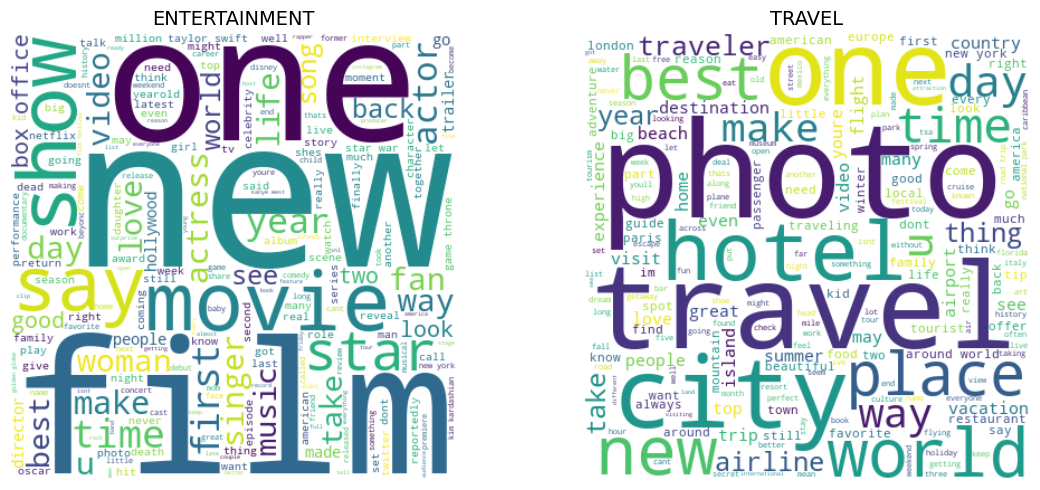

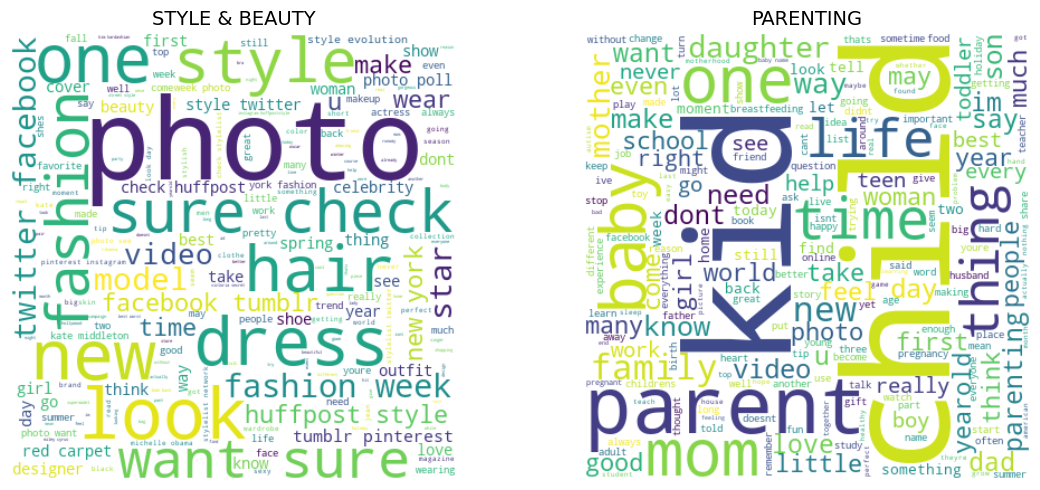

In [38]:
# WordCloud per category 

categories = df['category'].unique()

# Show first 4 categories, two wordclouds per row
for i in range(0, 10, 2):  # step 2 to get pairs
    cat1 = categories[i]
    cat2 = categories[i+1]

    text1 = " ".join(df[df['category']==cat1]['final_text'])
    text2 = " ".join(df[df['category']==cat2]['final_text'])

    wc1 = WordCloud(width=400, height=400, background_color="white").generate(text1)
    wc2 = WordCloud(width=400, height=400, background_color="white").generate(text2)

    # Create horizontal subplot
    fig, axes = plt.subplots(1, 2, figsize=(12,5))
    
    axes[0].imshow(wc1, interpolation="bilinear")
    axes[0].axis("off")
    axes[0].set_title(f"{cat1}", fontsize=14)

    axes[1].imshow(wc2, interpolation="bilinear")
    axes[1].axis("off")
    axes[1].set_title(f"{cat2}", fontsize=14)

    plt.tight_layout()
    plt.show()

## **3. Model Development and Training :**

## **Based on TF-IDF** 
### 1. *Logistic Regression*
### 2. *Naive Bayes*
### 3. *Support Vector Machine (SVM)*
### 4. *Random Forest*
## **Based on Word2Vec, or embeddings** 
### 5. *MLP Neural Network Metrics*

## **4. Model Evaluation :**

In [40]:
eval_table = pd.concat([result1_cv, result2_cv, result3_cv, result4_cv, result5_cv])
final_result = eval_table.sort_values(by=['F1-score','ROC-AUC'], ascending=False)
final_result

Model  Accuracy  Precision    Recall  \
1     Logistic Regression (5-fold CV)  0.788258   0.789444  0.788258   
3  Support Vector Machine (5-fold CV)  0.784345   0.784434  0.784345   
2             Naive Bayes (5-fold CV)  0.769940   0.774185  0.769940   
5           MLP (Word2Vec, 5-fold CV)  0.722267   0.722446  0.722267   
4           Random Forest (5-fold CV)  0.701983   0.703623  0.701983   

   F1-score   ROC-AUC  
1  0.787795  0.970849  
3  0.783958  0.967306  
2  0.768397  0.968739  
5  0.721325  0.956425  
4  0.700248  0.947115

## Top Performing Models :

**Logistic Regression is our best model overall.**

* Accuracy = 0.788258 (highest of all).

* F1-score = 0.787795 (best overall balance).

* ROC-AUC = 0.9708 (excellent class separation).

***Conclusion: Strong, reliable, and best suited for our dataset.***

**Support Vector Machine (SVM) is the second-best model.**

* Accuracy = 0.784345.

* F1-score = 0.783958.

* ROC-AUC = 0.967306.

***Very close to Logistic Regression, but slightly weaker in ROC-AUC and F1.***

**Naive Bayes is also competitive.**

* Accuracy = 0.769940.

* F1-score = 0.768397.

* ROC-AUC = 0.9688 (almost equal to Logistic Regression).

***Strong in AUC, but slightly lower in precision/recall***

# ***Thank You***